In [1]:
import numpy as np
import scipy as sp
import pandas as pd
pd.set_option("display.max_columns", 1000)
pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import time
import matplotlib
import seaborn as sns
import networkx as nx
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

matplotlib.style.use('fivethirtyeight')

Для начала я решил использовать модель "bag of words" и меру TF-IDF(в данном случае использую TfidfVectorizer), обучаю логистическую регрессию с L2-регуляризацией

Для фильтрации текста я решил использовать код, часть которого написана в книге "Основы Big Data и Data Science"(только вместо стеммера я использую лемматайзер)

In [2]:
stopwords = stopwords.words('english')
manual_stopwords = [',', '.', ')', '(', '-', "'",
                    '"', "'" '=', ';', 's', "'ve", '*', ':', 
                    "\\", "\/", "\r", "\n", "\t", '}', '{',
                    '_', '+', '#', '$', '@', '%', '^', 
                    '~', '``', "''", '""', '--', 
                    '!', '?', '[', ']', "'s", 'e.g'
                    "'m", "n't", 'r', 'etc', 'etc.', 
                    '`', '№', "^", "<", ">", "<=", ">=",
                    "^{", "}^", "^}"
                    ]

lmtzr = nltk.stem.WordNetLemmatizer()

def wordStemmer(word_row):
    stemmed = [stemmer.stem(word) for word in word_row]
    return stemmed

def wordFilter(excluded, wordrow):
    filtered = [word for word in wordrow if word not in excluded]
    return filtered

def wordLemmatizer(word_row):
    lemmatized = [lmtzr.lemmatize(word) for word in word_row]
    return lemmatized

def lowerCaseArray(wordrow):
    lowercased = [word.lower() for word in wordrow]
    return lowercased

def data_processing(dt, manual_stopwords):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+|[^\w\s]+')
    
    wordrow = tokenizer.tokenize(dt)
    wordrow_lowercased = lowerCaseArray(wordrow)
    wordrow_nostopwords = wordFilter(stopwords, wordrow_lowercased)
    wordrow_nostopwords = wordFilter(manual_stopwords, wordrow_nostopwords)
    wordrow_lemm = wordLemmatizer(wordrow_nostopwords)
    wordrow_stemmed = wordrow_lemm
        
    return wordrow_stemmed

def del_hapaxes(dt):
    freqs = nltk.FreqDist(dt)
    hapaxes = freqs.hapaxes()
    row = wordFilter(hapaxes, dt)
    return row

def to_str(l):
    return " ".join(l)



Считываем данные:

In [3]:
train = pd.read_csv('./train.csv', encoding="utf-8")
test = pd.read_csv('./test.csv', encoding="utf-8")

train.fillna('', inplace=True)
test.fillna('', inplace=True)

In [4]:
train['question1'].apply(str)
train['question2'].apply(str)

test['question1'].apply(str)
test['question2'].apply(str)

0          Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?                                                                                     
1          How much cost does hair transplant require?                                                                                                              
2          What you send money to China?                                                                                                                            
3          What foods fibre?                                                                                                                                        
4          How their can I start reading?                                                                                                                           
5          I admire I am considering of buying insurance from them                                                                                                  
6         

In [5]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [6]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,2,What but is the best way to send money from China to the US?,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


Фильтруем текст, подготавливаем данные для тренировки модели:

In [7]:
train['question1'] = train['question1'].apply(lambda x: data_processing(x, manual_stopwords))
train['question2'] = train['question2'].apply(lambda x: data_processing(x, manual_stopwords))

In [8]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,1,3,4,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, kohinoor, koh, noor, diamond, back]",0
2,2,5,6,"[increase, speed, internet, connection, using, vpn]","[internet, speed, increased, hacking, dns]",0
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, 23, 24, }[/, math, divided, 24, 23]",0
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, methane, carbon, di, oxide]","[fish, would, survive, salt, water]",0


Готовим тестовые данные:

In [9]:
test['question1'] = test['question1'].apply(lambda x: data_processing(x, manual_stopwords))
test['question2'] = test['question2'].apply(lambda x: data_processing(x, manual_stopwords))

In [10]:
test.head()

,test_id,question1,question2
0,0,"[surface, pro, 4, compare, ipad, pro]","[microsoft, choose, core, m3, core, i3, home, surface, pro, 4]"
1,1,"[hair, transplant, age, 24, much, would, cost]","[much, cost, hair, transplant, require]"
2,2,"[best, way, send, money, china, u]","[send, money, china]"
3,3,"[food, emulsifier]","[food, fibre]"
4,4,"[aberystwyth, start, reading]","[start, reading]"


Приводим профильтрованные запросы к строкам, чтобы Vectorizer мог с ними работать:

In [11]:
train['question1'] = train['question1'].apply(lambda x: to_str(x))
train['question2'] = train['question2'].apply(lambda x: to_str(x))

test['question1'] = test['question1'].apply(lambda x: to_str(x))
test['question2'] = test['question2'].apply(lambda x: to_str(x))

Сохраним отфильтрованный датасет:

In [12]:
train.to_csv("my_train.csv", sep='\t', encoding='utf-8', index=False)
test.to_csv("my_test.csv", sep='\t', encoding='utf-8', index=False)

Посмотрим на количество дубликатов в 'train.csv':

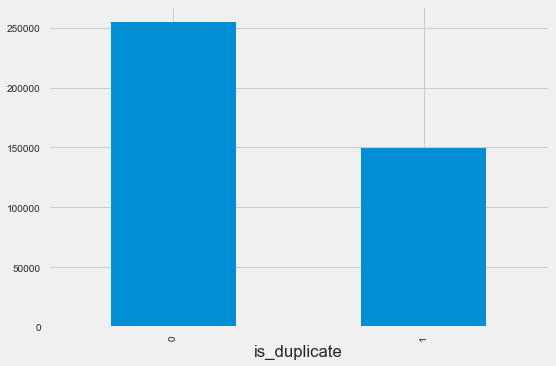

In [13]:
train.groupby("is_duplicate")['id'].count().plot.bar()

Эта часть взята из этого(https://www.kaggle.com/wantedfails/shallow-benchmark-0-31675-lb-1c2a7e) kernel'а:

In [14]:
#%% load train data

#trainDF = pd.read_csv('./train.csv')
trainDF = train
del train
#trainDF = trainDF.dropna(how="any").reset_index(drop=True)

#trainDF.iloc[:7,3:]#.ix[:7,3:]



In [21]:
manual_stopwords = [',', '.', ')', '(', '-', "'",
                    '"', "'" '=', ';', 's', "'ve", '*', ':', 
                    "\\", "\/", "\r", "\n", "\t", '}', '{',
                    '_', '+', '#', '$', '@', '%', '^', 
                    '~', '``', "''", '""', '--', 
                    '!', '?', '[', ']', "'s", 'e.g'
                    "'m", "n't", 'r', 'etc', 'etc.', 
                    '`', '№', "^", "<", ">", "<=", ">=",
                    "^{", "}^", "^}"
                    ]

#%% create dictionary and extract BOW features from questions
featureExtractionStartTime = time.time()

maxNumFeatures = 300

BagOfWordsExtractor = TfidfVectorizer(max_df=0.999, min_df=1000, max_features=maxNumFeatures,
                                      analyzer='char', ngram_range=(1,6), 
                                      stop_words=stopwords.extend(manual_stopwords),
                                      binary=True, lowercase=True)
del manual_stopwords

BagOfWordsExtractor.fit(pd.concat((trainDF.ix[:,'question1'],trainDF.ix[:,'question2'])))

trainQuestion1_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question1'])
trainQuestion2_BOW_rep = BagOfWordsExtractor.transform(trainDF.ix[:,'question2'])
lables = np.array(trainDF.ix[:,'is_duplicate'])

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))

feature extraction took 5.06 minutes


In [23]:
crossValidationStartTime = time.time()

numCVSplits = 8
numSplitsToBreakAfter = 2

X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int)
y = (lables)

logisticRegressor = LogisticRegression(C=0.1, penalty='l2', solver='sag', 
                                                    class_weight={1: 0.472008228977, 0: 1.30905513329})


logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []

print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')

---------------------------------------------
fold 1 took 0.19 minutes: accuracy = 0.645, log loss = 0.6481, AUC = 0.756
fold 2 took 0.20 minutes: accuracy = 0.644, log loss = 0.6525, AUC = 0.751
---------------------------------------------
cross validation took 0.41 minutes
mean CV: accuracy = 0.644, log loss = 0.6503, AUC = 0.754
---------------------------------------------


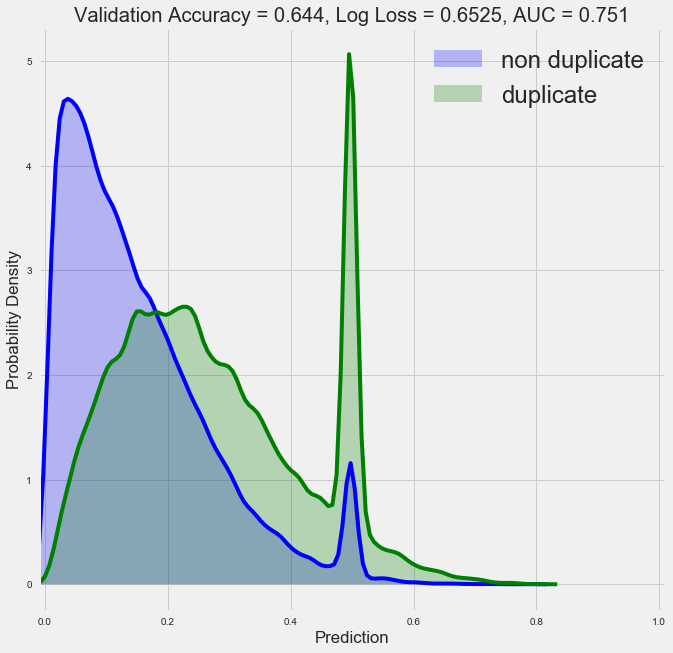

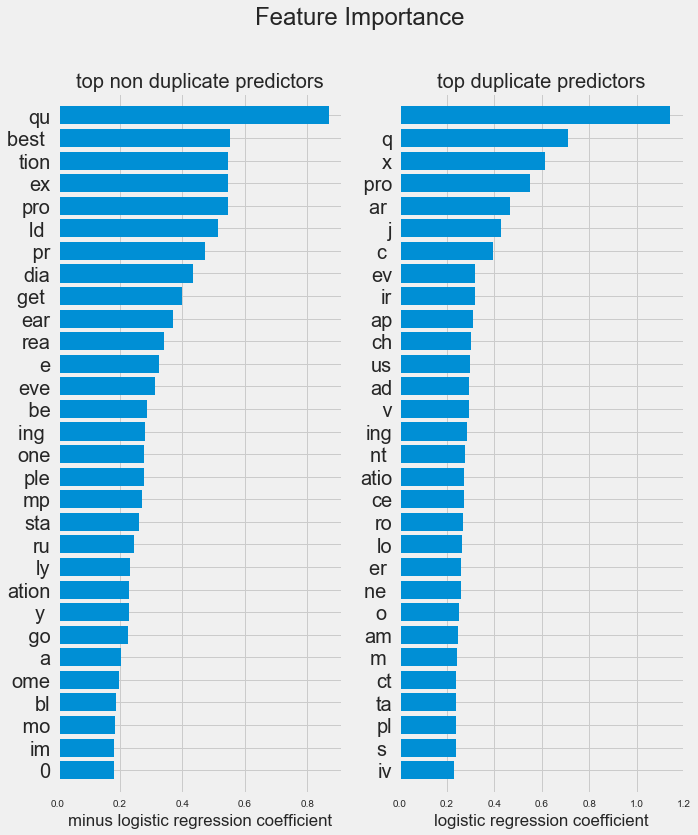

In [24]:
#%% show prediction distribution and "feature importance"

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure()
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction')
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1)
plt.title('top non duplicate predictors')
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center');
plt.ylim(-1,numFeaturesToShow)
ax.set_yticks(range(numFeaturesToShow))
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2)
plt.title('top duplicate predictors')
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center') 
plt.ylim(-1,numFeaturesToShow)
ax.set_yticks(range(numFeaturesToShow))
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

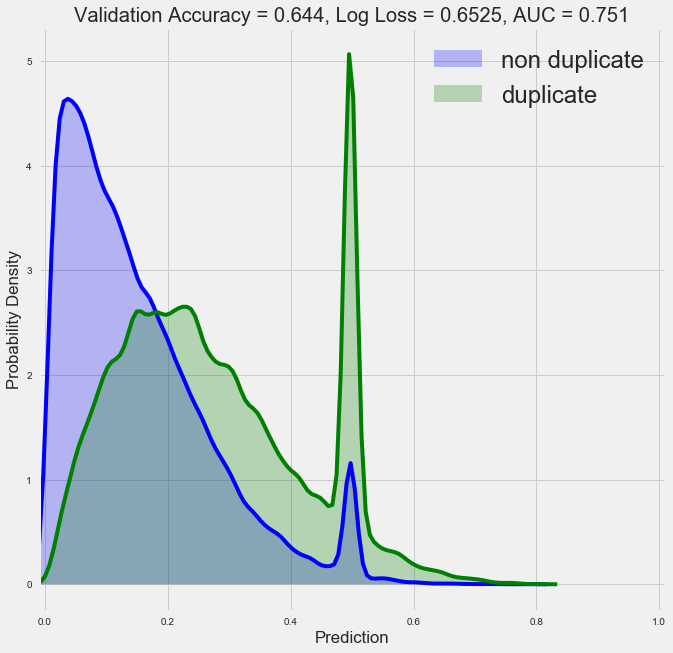

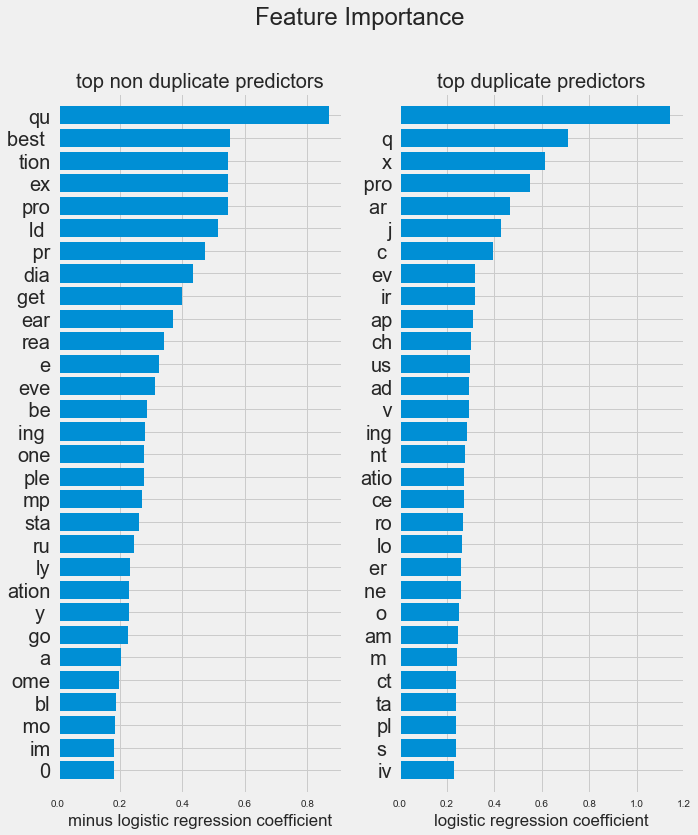

In [25]:
#%% show prediction distribution and "feature importance"

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure()
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density')
plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BagOfWordsExtractor.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors')
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center')
plt.ylim(-1,numFeaturesToShow)
ax.set_yticks(range(numFeaturesToShow)) 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2)
plt.title('top duplicate predictors')
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center')
plt.ylim(-1,numFeaturesToShow)
ax.set_yticks(range(numFeaturesToShow))
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [27]:
#%% train on full training data

trainingStartTime = time.time()

logisticRegressor = LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)



trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))

full training took 0.20 minutes


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


predicting on test took 14.03 minutes


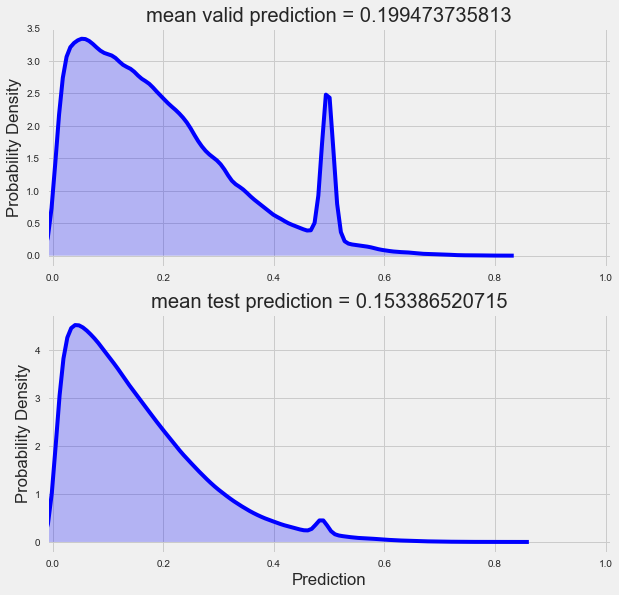

In [28]:
#%% load test data, extract features and make predictions

testPredictionStartTime = time.time()

testDF = test
del test
#testDF = pd.read_csv('./test.csv')
#testDF.ix[testDF['question1'].isnull(),['question1','question2']] = ' '
#testDF.ix[testDF['question2'].isnull(),['question1','question2']] = ' '

testQuestion1_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BagOfWordsExtractor.transform(testDF.ix[:,'question2'])

X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)

# quick fix to avoid memory errors
seperators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure()
plt.subplot(2,1,1)
sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01)
plt.ylabel('Probability Density')
plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2)
sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01)
plt.xlabel('Prediction')
plt.ylabel('Probability Density')
plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))

In [29]:
#%% create a submission

submissionName = 'my_submission_42'

submission = pd.DataFrame()
submission['test_id'] = testDF['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)

Итоговое значение log_loss при таком решении на public leaderboard = 0.40055

Поэтому я решил посмотреть в сторону градиентного бустинга(и библиотеки xgboost), вместо логистической регрессии.

Сначала я смотрел в сторону kernel'ов аналогичных данному: https://www.kaggle.com/aprooks/data-analysis-xgboost-starter-0-35460-lb

Позже я использовал этот kernel(https://www.kaggle.com/act444/lb-0-158-xgb-handcrafted-leaky/comments), слегка меняя там параметры модели и заменяя одни признаки на другие(эти признаки были выделены abhishek thakur: https://www.kaggle.com/c/quora-question-pairs/discussion/31284).

Именно это решение дало log loss = 0.15857 на public leaderboard.

In [ ]:
import argparse
import functools
from collections import defaultdict

import numpy as np
import pandas as pd
import xgboost as xgb

from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split

from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer


def word_match_share(row, stops=None):
    q1words = {}
    q2words = {}
    for word in row['question1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['question2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def jaccard(row):
    wic = set(row['question1']).intersection(set(row['question2']))
    uw = set(row['question1']).union(row['question2'])
    if len(uw) == 0:
        uw = [1]
    return (len(wic) / len(uw))

def common_words(row):
    return len(set(row['question1']).intersection(set(row['question2'])))

def total_unique_words(row):
    return len(set(row['question1']).union(row['question2']))

def total_unq_words_stop(row, stops):
    return len([x for x in set(row['question1']).union(row['question2']) if x not in stops])

def wc_diff(row):
    return abs(len(row['question1']) - len(row['question2']))

def wc_ratio(row):
    l1 = len(row['question1'])*1.0 
    l2 = len(row['question2'])
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def wc_diff_unique(row):
    return abs(len(set(row['question1'])) - len(set(row['question2'])))

def wc_ratio_unique(row):
    l1 = len(set(row['question1'])) * 1.0
    l2 = len(set(row['question2']))
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def wc_diff_unique_stop(row, stops=None):
    return abs(len([x for x in set(row['question1']) if x not in stops]) - len([x for x in set(row['question2']) if x not in stops]))

def wc_ratio_unique_stop(row, stops=None):
    l1 = len([x for x in set(row['question1']) if x not in stops])*1.0 
    l2 = len([x for x in set(row['question2']) if x not in stops])
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def same_start_word(row):
    if not row['question1'] or not row['question2']:
        return np.nan
    return int(row['question1'][0] == row['question2'][0])

def char_diff(row):
    return abs(len(''.join(row['question1'])) - len(''.join(row['question2'])))

def char_ratio(row):
    l1 = len(''.join(row['question1'])) 
    l2 = len(''.join(row['question2']))
    if l2 == 0:
        return np.nan
    if l1 / l2:
        return l2 / l1
    else:
        return l1 / l2

def char_diff_unique_stop(row, stops=None):
    return abs(len(''.join([x for x in set(row['question1']) if x not in stops])) - len(''.join([x for x in set(row['question2']) if x not in stops])))


def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)
    
def tfidf_word_match_share_stops(row, stops=None, weights=None):
    q1words = {}
    q2words = {}
    for word in row['question1']:
        if word not in stops:
            q1words[word] = 1
    for word in row['question2']:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

def tfidf_word_match_share(row, weights=None):
    q1words = {}
    q2words = {}
    for word in row['question1']:
        q1words[word] = 1
    for word in row['question2']:
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R


def build_features(data, stops, weights):
    X = pd.DataFrame()
    f = functools.partial(word_match_share, stops=stops)
    X['word_match'] = data.apply(f, axis=1, raw=True) #1

    f = functools.partial(tfidf_word_match_share, weights=weights)
    X['tfidf_wm'] = data.apply(f, axis=1, raw=True) #2

    f = functools.partial(tfidf_word_match_share_stops, stops=stops, weights=weights)
    #tfidf_ = TfidfVectorizer(ngram_range=(1,3), stop_words=stops)
    #xxx = tfidf.fit_transform((data['question1']).extend(data['question2']))
    #f = 
    X['tfidf_wm_stops'] = data.apply(f, axis=1, raw=True) #3

    X['jaccard'] = data.apply(jaccard, axis=1, raw=True) #4
    X['wc_diff'] = data.apply(wc_diff, axis=1, raw=True) #5
    X['wc_ratio'] = data.apply(wc_ratio, axis=1, raw=True) #6
    X['wc_diff_unique'] = data.apply(wc_diff_unique, axis=1, raw=True) #7
    X['wc_ratio_unique'] = data.apply(wc_ratio_unique, axis=1, raw=True) #8

    f = functools.partial(wc_diff_unique_stop, stops=stops)    
    X['wc_diff_unq_stop'] = data.apply(f, axis=1, raw=True) #9
    f = functools.partial(wc_ratio_unique_stop, stops=stops)    
    X['wc_ratio_unique_stop'] = data.apply(f, axis=1, raw=True) #10

    X['same_start'] = data.apply(same_start_word, axis=1, raw=True) #11
    X['char_diff'] = data.apply(char_diff, axis=1, raw=True) #12

    f = functools.partial(char_diff_unique_stop, stops=stops) 
    X['char_diff_unq_stop'] = data.apply(f, axis=1, raw=True) #13

#     X['common_words'] = data.apply(common_words, axis=1, raw=True)  #14
    X['total_unique_words'] = data.apply(total_unique_words, axis=1, raw=True)  #15

    f = functools.partial(total_unq_words_stop, stops=stops)
    X['total_unq_words_stop'] = data.apply(f, axis=1, raw=True)  #16
    
    X['char_ratio'] = data.apply(char_ratio, axis=1, raw=True) #17    

    return X


def main():
    
    df_train = pd.read_csv('./train_features.csv', encoding="ISO-8859-1")
    X_train_ab = df_train.iloc[:, 2:-1]
    X_train_ab = X_train_ab.drop('euclidean_distance', axis=1)
    X_train_ab = X_train_ab.drop('jaccard_distance', axis=1)

    df_train = pd.read_csv('./train.csv')
    df_train = df_train.fillna(' ')

    df_test = pd.read_csv('./test.csv')
    ques = pd.concat([df_train[['question1', 'question2']], \
        df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')
    q_dict = defaultdict(set)
    for i in range(ques.shape[0]):
            q_dict[ques.question1[i]].add(ques.question2[i])
            q_dict[ques.question2[i]].add(ques.question1[i])

    def q1_freq(row):
        return(len(q_dict[row['question1']]))
        
    def q2_freq(row):
        return(len(q_dict[row['question2']]))
        
    def q1_q2_intersect(row):
        return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

    df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect, axis=1, raw=True)
    df_train['q1_freq'] = df_train.apply(q1_freq, axis=1, raw=True)
    df_train['q2_freq'] = df_train.apply(q2_freq, axis=1, raw=True)

    df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect, axis=1, raw=True)
    df_test['q1_freq'] = df_test.apply(q1_freq, axis=1, raw=True)
    df_test['q2_freq'] = df_test.apply(q2_freq, axis=1, raw=True)

    test_leaky = df_test.loc[:, ['q1_q2_intersect','q1_freq','q2_freq']]
    del df_test

    train_leaky = df_train.loc[:, ['q1_q2_intersect','q1_freq','q2_freq']]

    # explore
    stops = set(stopwords.words("english"))

    manual_stopwords = set([',', '.', ')', '(', '-', "'",
                    '"', "'" '=', ';', 's', "'ve", '*', ':', 
                    "\\", "\/", "\r", "\n", "\t", '}', '{',
                    '_', '+', '#', '$', '@', '%', '^', 
                    '~', '``', "''", '""', '--', 
                    '!', '?', '[', ']', "'s", 'e.g'
                    "'m", "n't", 'r', 'etc', 'etc.', 
                    '`', '№', "^", "<", ">", "<=", ">=",
                    "^{", "}^", "^}"
                    ])
    
    stops |= manual_stopwords
    
    df_train['question1'] = df_train['question1'].map(lambda x: str(x).lower().split())
    df_train['question2'] = df_train['question2'].map(lambda x: str(x).lower().split())

    train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())

    words = [x for y in train_qs for x in y]
    counts = Counter(words)
    weights = {word: get_weight(count) for word, count in counts.items()}

    print('Building Features')
    X_train = build_features(df_train, stops, weights)
    X_train = pd.concat((X_train, X_train_ab, train_leaky), axis=1)
    y_train = df_train['is_duplicate'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42742)

    #UPDownSampling
    pos_train = X_train[y_train == 1]
    neg_train = X_train[y_train == 0]
    X_train = pd.concat((neg_train, pos_train.iloc[:int(0.8*len(pos_train))], neg_train))
    y_train = np.array([0] * neg_train.shape[0] + [1] * pos_train.iloc[:int(0.8*len(pos_train))].shape[0] + [0] * neg_train.shape[0])
    print(np.mean(y_train))
    del pos_train, neg_train

    pos_valid = X_valid[y_valid == 1]
    neg_valid = X_valid[y_valid == 0]
    X_valid = pd.concat((neg_valid, pos_valid.iloc[:int(0.8 * len(pos_valid))], neg_valid))
    y_valid = np.array([0] * neg_valid.shape[0] + [1] * pos_valid.iloc[:int(0.8 * len(pos_valid))].shape[0] + [0] * neg_valid.shape[0])
    print(np.mean(y_valid))
    del pos_valid, neg_valid


    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 7
    params['subsample'] = 0.6
    params['base_score'] = 0.2
    #
    params['scale_pos_weight'] = 0.15
    params['seed'] = 42

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_valid, label=y_valid)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 12000, watchlist, early_stopping_rounds=355, verbose_eval=200)
    print(log_loss(y_valid, bst.predict(d_valid)))
    
    print("Saving model...")
    
    bst.save_model("my_model_1.mdl")


    print('Building Test Features')
    df_test = pd.read_csv('./test_features.csv', encoding="ISO-8859-1")
    x_test_ab = df_test.iloc[:, 2:-1]
    x_test_ab = x_test_ab.drop('euclidean_distance', axis=1)
    x_test_ab = x_test_ab.drop('jaccard_distance', axis=1)
    
    df_test = pd.read_csv('./test.csv')
    df_test = df_test.fillna(' ')

    df_test['question1'] = df_test['question1'].map(lambda x: str(x).lower().split())
    df_test['question2'] = df_test['question2'].map(lambda x: str(x).lower().split())
    
    x_test = build_features(df_test, stops, weights)
    x_test = pd.concat((x_test, x_test_ab, test_leaky), axis=1)
    d_test = xgb.DMatrix(x_test)
    p_test = bst.predict(d_test)
    
    print('Saving...')
    
    submission = pd.read_csv('./sample_submission.csv')
    submission['is_duplicate'] = p_test
    submission.to_csv('leak_submission.csv', index=False)
    
    print("Done!")
    
main()


Отчасти я также вдохновлялся следующими kernel'ами:
- https://www.kaggle.com/liuxiao1028/quick-guide-for-making-0-10112-score-technosphere

К сожалению, я смог принять участие в этом конкурсе только на последней неделе.

Из интересных моделей я хотел бы попробовать:
- рекуррентные нейронные сети(и LSTM)
- сверточные нейронные сети
- использование word2vec и doc2vec для оценки близости слов и документов
- кластеризация, к примеру с помощью WordNet или gensim
- наработки Стэнфорда(https://nlp.stanford.edu/software/)
- средства библиотек glove, spacy

Спасибо за интересную задачу!